In [1]:
import os
import sys
sys.path.append('../')

from PIL import Image
import torch
import numpy as np
from datasets.build import make_dataloader

In [2]:
root = '/home/data/vision7/A3D_2.0/frames/'
train_split = '../A3D_2.0_train.json'
mode = 'rgb'

train_dataloader = make_dataloader(root,
                                       train_split, 
                                       mode,
                                       phase='train', 
                                       seq_len=16,
                                       overlap=15,
                                       max_iters=None, 
                                       batch_per_gpu=2,
                                       num_workers=0, 
                                       shuffle=True, 
                                       distributed=False,
                                       with_normal=False)

======== Number of samples of all categories ========
normal:0
ego: start_stop_or_stationary:1485
ego: moving_ahead_or_waiting:10108
ego: lateral:13035
ego: oncoming:7167
ego: turning:20610
ego: pedestrian:590
ego: obstacle:1812
ego: leave_to_right:4002
ego: leave_to_left:5407
other: start_stop_or_stationary:832
other: moving_ahead_or_waiting:7053
other: lateral:8342
other: oncoming:2485
other: turning:17439
other: pedestrian:1286
other: obstacle:2047
other: leave_to_right:3722
other: leave_to_left:3822
unknown:0
Number of used video: 111244


In [3]:
train_dataloader.batch_sampler.sampler

In [4]:
from collections import defaultdict
from tqdm import tqdm

label_counts = defaultdict(int)
for i, batch in enumerate(tqdm(train_dataloader)):
    imgs, labels, vid, start, end = batch
    for label in labels:
        label_counts[int(label.nonzero())] += 1
    if i > 100:
        break

  0%|          | 101/55622 [01:08<10:44:15,  1.44it/s]

In [5]:
label_counts

defaultdict(int,
            {5: 42,
             8: 6,
             11: 17,
             14: 29,
             12: 11,
             7: 2,
             9: 15,
             13: 3,
             3: 18,
             2: 20,
             16: 6,
             1: 1,
             18: 10,
             4: 16,
             17: 6,
             15: 2})

In [21]:
id_to_show = 0
imgs_to_show = []
viz_imgs = (imgs+1)/2
T = viz_imgs.shape[2]

for t in range(T):
    imgs_to_show.append(Image.fromarray((viz_imgs[id_to_show,:,t,...].permute(1,2,0).numpy()*255).astype(np.uint8)))

In [22]:
vid

('0RJPQ_97dcs_000199', '0RJPQ_97dcs_000199')

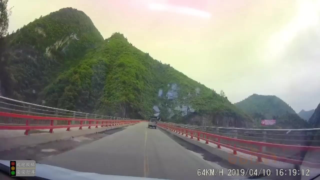

In [23]:
imgs_to_show[0]

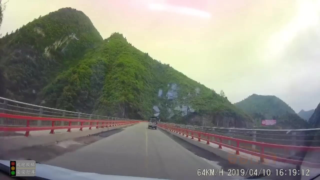

In [26]:
imgs_to_show[9]

In [27]:
label

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Debug the trained I3D
* the top 1 accuracy is always 0.0, why?
* loss reduce fast and saturated after ~1300 iters

In [1]:
import numpy as np
import torch
import sys
sys.path.append('../')
from pytorch_i3d import InceptionI3d
from datasets.build import make_dataloader
from model_serialization import load_state_dict
import torch.nn.functional as F

from PIL import Image

import matplotlib.animation as animation
import matplotlib.pyplot as plt

from IPython.display import HTML

from tqdm import tqdm
import pdb
%matplotlib inline

In [6]:
root = '/home/data/vision7/A3D_2.0/frames/'
val_split = '../A3D_2.0_val.json'
mode = 'rgb'
distributed = False

val_dataloader = make_dataloader(root,
                                 val_split, 
                                 mode,
                                 seq_len=16,
                                 overlap=0,
                                 phase='val', 
                                 max_iters=None, 
                                 batch_per_gpu=2,
                                 num_workers=0, 
                                 shuffle=False, 
                                 distributed=distributed,
                                 with_normal=False)

i3d = InceptionI3d(val_dataloader.dataset.num_classes, in_channels=3)
# load_state_dict(i3d, torch.load('/home/data/vision7/brianyao/DATA/i3d_outputs/i3d_16_10_class/002800.pt'))
load_state_dict(i3d, torch.load('/home/data/vision7/brianyao/DATA/i3d_outputs/8popj80j/024000.pt'))

======== Number of samples of all categories ========
normal:0
ego: start_stop_or_stationary:35
ego: moving_ahead_or_waiting:338
ego: lateral:429
ego: oncoming:224
ego: turning:608
ego: pedestrian:33
ego: obstacle:64
ego: leave_to_right:104
ego: leave_to_left:144
other: start_stop_or_stationary:44
other: moving_ahead_or_waiting:230
other: lateral:243
other: oncoming:60
other: turning:569
other: pedestrian:46
other: obstacle:85
other: leave_to_right:144
other: leave_to_left:128
unknown:0
Number of used video: 3528


In [3]:
import sys
sys.path.append('../')
from train_i3d import do_val
from datasets.evaluation.evaluation import ActionClassificationEvaluator

device = torch.device('cuda')
i3d.to(device)
i3d.eval()

evaluator = ActionClassificationEvaluator(cfg=None,
                                              dataset=val_dataloader.dataset,
                                              split='val',
                                              mode='accuracy',#'mAP',
                                              output_dir='',
                                              with_normal=False)

do_val(i3d, val_dataloader, device, distributed=False,logger=None, output_dir='debug_trash/', train_iters=0, evaluator=evaluator)

  0%|          | 36/8445 [00:15<1:02:14,  2.25it/s]

KeyboardInterrupt: 

In [9]:
results = {}
all_labels = {}
for iters, data in enumerate(tqdm(val_dataloader)):
    # get the inputs
    inputs, labels, video_names, start, end = data
    
    # wrap them in Variable
    inputs = inputs.to(device)
    t = inputs.size(2)

    per_frame_logits = i3d(inputs)
    pdb.set_trace()
    per_frame_logits = per_frame_logits.mean(dim=-1).detach().cpu()
    
    for batch_id, vid in enumerate(video_names):
        frame_id = int((start[batch_id] + end[batch_id])/2)

        pred = per_frame_logits[batch_id]
        if vid not in results:
            results[vid] = {}
            all_labels[vid] = {}
        assert frame_id not in results[vid]
        results[vid][frame_id] = pred
        all_labels[vid][frame_id] = labels[batch_id]
    del inputs
    if iters > 100:
            break



  0%|          | 0/111244 [00:00<?, ?it/s]



RuntimeError: CUDA out of memory. Tried to allocate 3.75 MiB (GPU 0; 11.91 GiB total capacity; 1.93 GiB already allocated; 5.56 MiB free; 5.73 MiB cached)

In [7]:
inputs.shape

torch.Size([1, 3, 32, 180, 320])

In [6]:
predictions = {}
scores = {}
label_arrays = {}
for vid, result in results.items():
    predictions[vid] = []
    scores[vid] = []
    label_arrays[vid] = []
    for k, v in result.items():
        score, label = v.softmax(dim=0).max(dim=0)
        predictions[vid].append(int(label))
        scores[vid].append(float(score))
        label_arrays[vid].append(int(all_labels[vid][k].max(dim=0)[1]))
        
    predictions[vid] = np.array(predictions[vid])
    scores[vid] = np.array(scores[vid])
    label_arrays[vid] = np.array(label_arrays[vid])

In [15]:
results['0RJPQ_97dcs_000897']

{155: tensor([-5.7222, -3.1499, -2.6052, -2.2956, -2.8868, -2.4745, -2.9564, -2.8542,
         -3.0652, -3.1912, -3.0028, -2.2681, -2.3942, -2.2075, -2.1444, -2.8566,
         -1.9753, -2.3225, -2.2467]),
 156: tensor([-5.7484, -3.2341, -2.5623, -2.1924, -2.8356, -2.4078, -2.7216, -2.9196,
         -2.9228, -3.0320, -3.2333, -2.4248, -2.4988, -2.3628, -2.3344, -2.9244,
         -1.9330, -2.3759, -2.3377]),
 157: tensor([-5.6595, -3.0948, -2.6245, -2.3420, -2.7248, -2.4903, -2.8912, -2.8045,
         -3.0402, -3.0683, -2.9041, -2.3454, -2.4454, -2.1416, -2.1116, -2.8466,
         -1.9515, -2.2613, -2.2027]),
 158: tensor([-5.8787, -3.1418, -2.6133, -2.1916, -2.8612, -2.3938, -2.5778, -2.7875,
         -3.0111, -3.1359, -3.0326, -2.5290, -2.5558, -2.2982, -2.3329, -2.8351,
         -2.1168, -2.6101, -2.5997]),
 159: tensor([-5.6455, -2.9782, -2.4199, -2.1343, -2.6718, -2.2624, -2.6492, -2.6797,
         -2.8996, -3.1569, -2.9114, -2.3488, -2.4373, -2.1856, -2.2411, -2.7220,
         -2.1

In [7]:
predictions

{'0RJPQ_97dcs_000199': array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 6, 8, 6, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7]),
 '0RJPQ_97dcs_000307': array([ 1,  1,  1,  1,  4,  4,  1,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5, 10, 10, 10, 10, 10, 10]),
 '0RJPQ_97dcs_000897': array([16, 16, 16, 16,  3, 16, 16, 16, 16, 16, 16,  6,  3,  3,  3,  5,  2,
         2,  2,  2,  2,  3,  3,  3, 13, 13, 13,  5, 13,  6])}

In [8]:
label_arrays

{'0RJPQ_97dcs_000199': array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
 '0RJPQ_97dcs_000307': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5]),
 '0RJPQ_97dcs_000897': array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])}

In [9]:
scores

{'0RJPQ_97dcs_000199': array([0.19884634, 0.2010902 , 0.22884157, 0.25978884, 0.21967307,
        0.23534788, 0.22379808, 0.27927342, 0.23794848, 0.22822635,
        0.2664794 , 0.23380741, 0.22847325, 0.22718094, 0.2263114 ,
        0.2074974 , 0.19672631, 0.18770531, 0.22151427, 0.19776909,
        0.19799188, 0.16115539, 0.21679248, 0.21192057, 0.18766429,
        0.18160655, 0.22745496, 0.17914549, 0.18154804, 0.15387399,
        0.1742322 , 0.14903526, 0.16001046, 0.13854429, 0.14187746,
        0.12708598, 0.13269579, 0.12577307, 0.13597083, 0.12770317,
        0.12733784, 0.12085867]),
 '0RJPQ_97dcs_000307': array([0.15655069, 0.16089126, 0.16533522, 0.18919756, 0.12116531,
        0.13548528, 0.12158296, 0.12202861, 0.15254927, 0.13204777,
        0.13556597, 0.14955793, 0.14370836, 0.14109813, 0.12723473,
        0.12293243, 0.12502463, 0.12897001, 0.13234431, 0.12925506,
        0.12612212, 0.12333746, 0.11207364, 0.11255144, 0.10509764,
        0.120612  , 0.11985483, 0.1085

In [55]:
id_to_show = 0
imgs_to_show = []
viz_imgs = (inputs.cpu()+1)/2
T = viz_imgs.shape[2]

for t in range(T):
    imgs_to_show.append(Image.fromarray((viz_imgs[id_to_show,:,t,...].permute(1,2,0).numpy()*255).astype(np.uint8)))

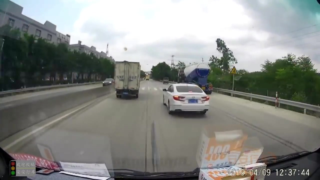

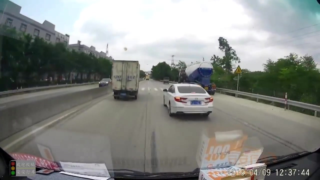

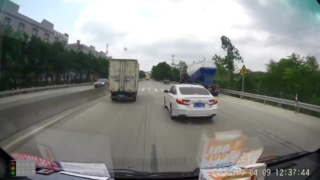

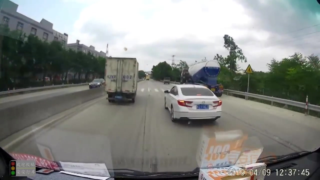

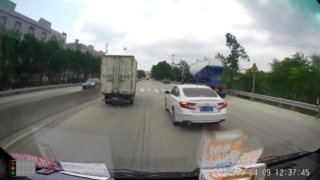

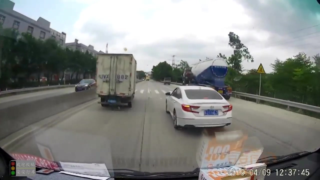

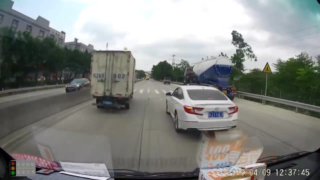

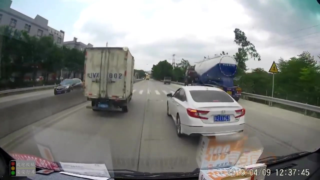

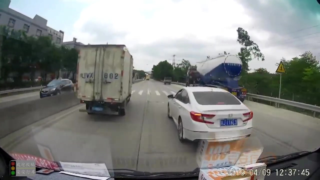

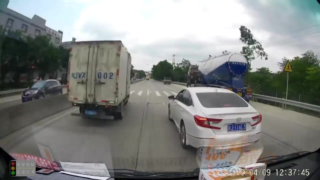

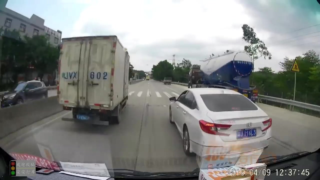

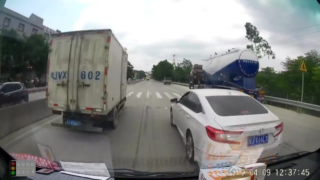

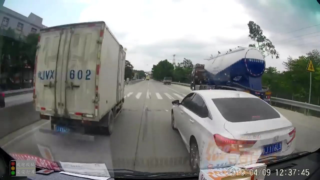

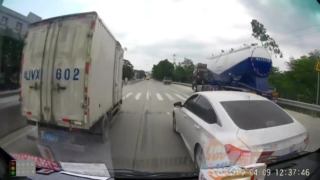

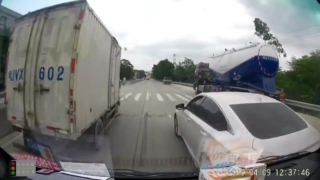

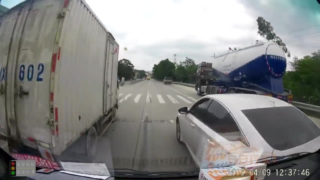

In [56]:
for img in imgs_to_show:
    display(img)

In [50]:
video_names

('0RJPQ_97dcs_000387',)